# State array analysis for single-particle tracks
Alec Heckert, Liza Dahal, Robert Tijan, Xavier Darzacq (2022) Recovering mixtures of fast-diffusing states from short single-particle trajectories eLife 11:e70169  
https://doi.org/10.7554/eLife.70169

## Imports

In [15]:
# main python packages
from glob import glob
import os
from os.path import join
from pathlib import Path

# 3rd party packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib_scalebar.scalebar as sb
import numpy as np
import pandas as pd
from saspt import StateArray, RBME
from saspt.lik import RBMELikelihood
import scipy.io

# locally installed package
import biteen_utilities as bu

# to suppress annoying warning
plt.rcParams["font.sans-serif"] = ["DejaVu Sans"]

## Read data
* example data courtesy of Dr. Lauren McCarthy  

In [ ]:
folder = r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren" # note the drive letter may be different on your computer

files = glob(join(folder, r"*_fits.mat")) # find all the fits files
phase_mask_files = glob(join(folder, r"*_PhaseMask.mat")) # find mask files

all_dfs = [] # initiate a list to hold DataFrames containing fits data
curr_max_id = 0

for i, file in enumerate(files):
    data = bu.slfile_to_df(file) # read SMALL-LABS fit file and convert to pandas DataFrame
    data = data[data['goodfit']==True] # only consider good fits
    data = bu.filter_by_nlocs(data, min_locs=6, max_locs=np.inf, track_col='track_id') # filter tracks by number of localizations
    data['movie #'] = i
    track_ids = data['track_id'].dropna().unique()
    n_ids = len(track_ids)
    new_ids = np.arange(n_ids) + curr_max_id
    curr_max_id = new_ids[-1] + 1
    data['track_id_unique'] = data['track_id'].replace(
        track_ids,
        new_ids
    )    
    all_dfs.append(data)

all_fits = pd.concat(all_dfs, ignore_index=True)
all_fits['roinum_unique'] = all_fits.groupby(['movie #', 'roinum']).ngroup() + 1

phase_masks = [scipy.io.loadmat(file)['PhaseMask'] for file in phase_mask_files]

## State array analysis

### Calculate state array for all data

In [ ]:
detections = all_fits.rename(columns={'col': 'x', 
                                       'row': 'y', 
                                       'track_id_unique': 'trajectory'})

rbme_likelihood = RBMELikelihood(
    pixel_size_um = 0.049, # um
    frame_interval = 0.04, # seconds
    focal_depth = np.inf,
    diff_coefs = np.logspace(-3, 1, 100),
    loc_errors = np.linspace(0, 0.1, 30)
    )

settings = dict(
    likelihood_type = RBME,
    pixel_size_um = 0.049, # um
    frame_interval = 0.04, # seconds
    focal_depth = np.inf,
    progress_bar = True,
)

SA = StateArray.from_detections(detections[['x', 'y', 'trajectory', 'frame']], **settings)
SA.likelihood = rbme_likelihood
SA.posterior_assignment_probabilities;

c:\Users\djfoust\Anaconda3\envs\saspt-dan\lib\site-packages\saspt\trajectory_group.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections[cls.DETECT_INDEX] = np.arange(len(detections), dtype=np.int64)


inferring posterior distribution...


100%|██████████| 200/200 [00:20<00:00,  9.80it/s]


### Secondary calculation, e.g. D_av for each trajectory

In [4]:
track_posteriors = SA.posterior_assignment_probabilities.sum(axis=1)
Dav_track = (track_posteriors * SA.diff_coefs[:,None]).sum(axis=0)
sa_detections = SA.trajectories.detections
sa_detections['D_av'] = Dav_track[sa_detections['trajectory']]

posterior_occs = SA.posterior_occs.sum(axis=1)

### Merge SA detections with input data

In [5]:
all_fits['track_id_SA'] = np.nan
all_fits.loc[sa_detections['detect_index'], 'track_id_SA'] = sa_detections['trajectory']
all_fits.loc[sa_detections['detect_index'], 'D_av'] = sa_detections['D_av']

all_fits['log10(D_av)'] = np.log10(all_fits['D_av'])

## Plotting

### Creating a custom colormap

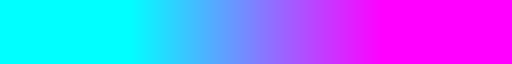

In [6]:
cmap = mpl.cm.cool

vmin = -3
vmax = 1
lmin = -2 # tracks with D_app < 10^-2 will appear cyan
lmax = 0 # tracks with D_app > 10^0 will appear magenta

x = np.linspace(0, 1, 256)
n_min = len(x[x<(lmin-vmin) / (vmax - vmin)])
n_max = len(x[x>(lmax-vmin) / (vmax - vmin)])

seg1 = np.array(n_min * [cmap(0.),])
seg2 = cmap(np.linspace(0, 1, 256-n_min-n_max))
seg3 = np.array(n_max * [cmap(1.),])

colors = np.vstack((seg1, seg2, seg3))

coolramp = mpl.colors.ListedColormap(colors=np.vstack((seg1, seg2, seg3)), N=256, name='cool_sat')
coolramp

### Render figures

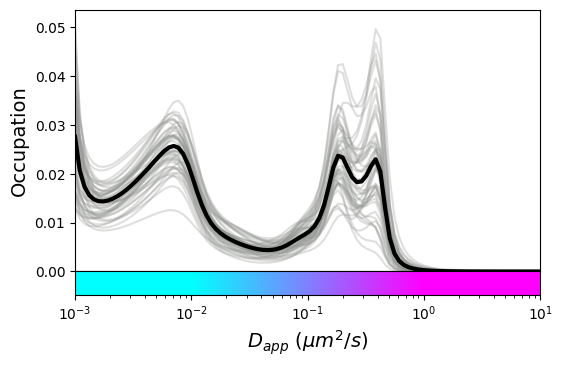

In [ ]:
all_figures = []
diff_coefs = SA.diff_coefs

fig, ax = plt.subplots(1, 1, figsize=(6,4))

cpo_max = 0

norm = mpl.colors.LogNorm(vmin=diff_coefs[0], vmax=diff_coefs[-1])
scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=coolramp)

for icell in all_fits['roinum_unique'].unique():
    cell_fits = all_fits[all_fits['roinum_unique'] == icell]
    cell_fits = cell_fits[~np.isnan(cell_fits['track_id_SA'])]
    cell_track_posteriors = track_posteriors[:, cell_fits['track_id_SA'].unique().astype('int')]

    cell_posterior_occs = (cell_track_posteriors * cell_fits.groupby('track_id_SA')['track_id_SA'].count().values).sum(axis=1) / len(cell_fits)
    if cell_posterior_occs.max() > cpo_max: cpo_max = cell_posterior_occs.max()

    ax.set_xscale('log')
    ax.set_xlim(left=diff_coefs[0], right=diff_coefs[-1])
    
    ax.plot(diff_coefs, 
            cell_posterior_occs,
            color='xkcd:grey',
            lw=1.5,
            alpha=0.3)

ax.set_ylabel('Occupation', fontsize=14)
ax.set_ylim(bottom=0, top=cpo_max*1.05)

ax.plot(diff_coefs,
        posterior_occs,color='xkcd:black',
               lw=3)
ax.set_xticks([])

cbar = plt.colorbar(scalar_mappable,
                orientation='horizontal',
                ticks=[1e-3, 1e-2, 1e-1, 1e0, 1e1],
                ax=ax,
                label=r'$D_{app}\ (\mu m^2/s)$',
                pad=0)

cbar.solids.set(alpha=1)
# cbar.set_label(fontsize=14)
cbar.ax.set_xticklabels(['$\\mathdefault{10^{-3}}$',
                        '$\\mathdefault{10^{-2}}$',
                        '$\\mathdefault{10^{-1}}$',
                        '$\\mathdefault{10^{0}}$',
                        '$\\mathdefault{10^{1}}$'])
# cbar.ax.tick_params(axis='x', labelsize=18)
cbar.set_label(r'$D_{app}\ (\mu m^2/s)$', fontsize=14)

all_figures.append(fig)

C:\Users\djfoust\AppData\Local\Temp\1\ipykernel_30244\1295789230.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2,1, figsize=(4,8))


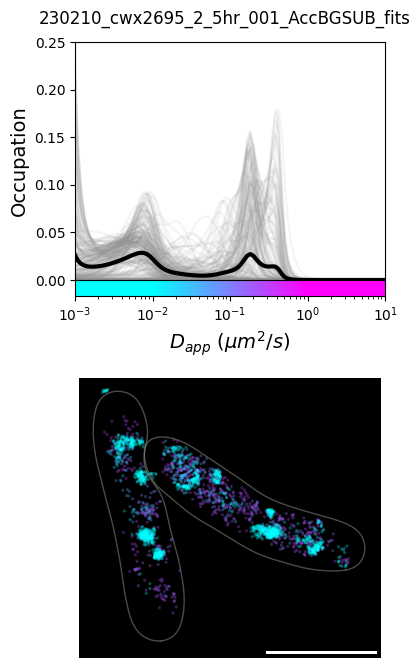

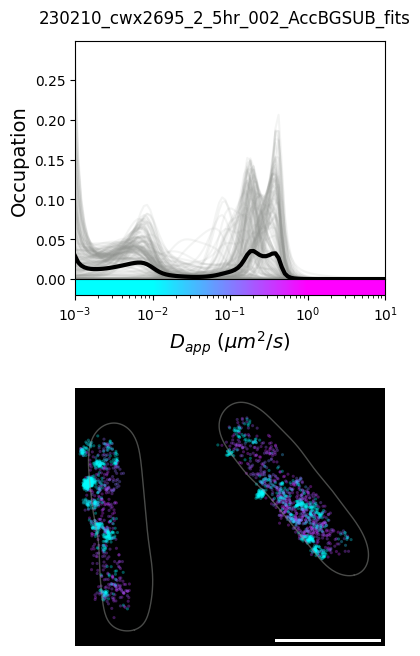

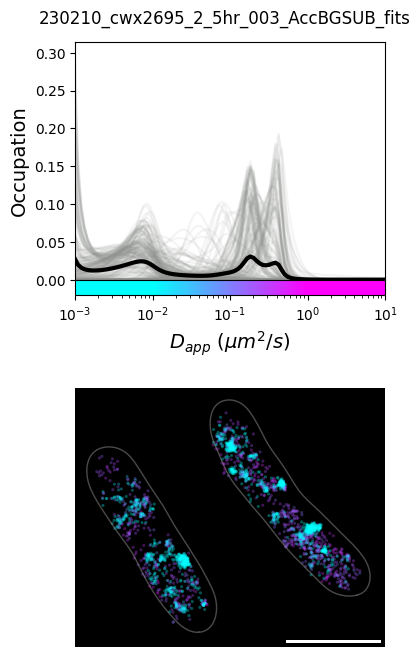

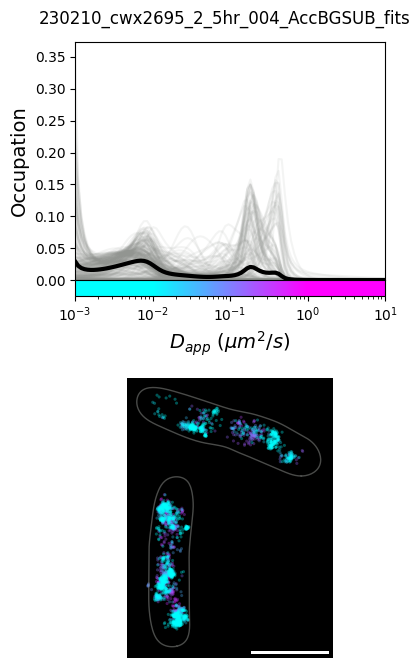

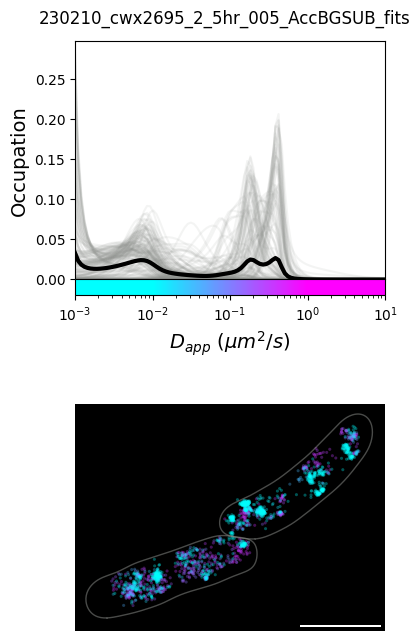

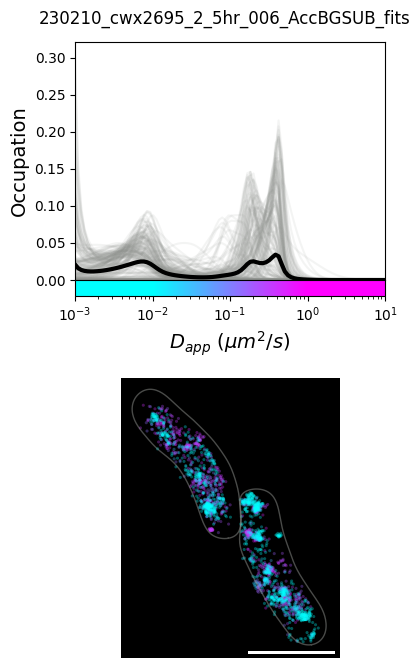

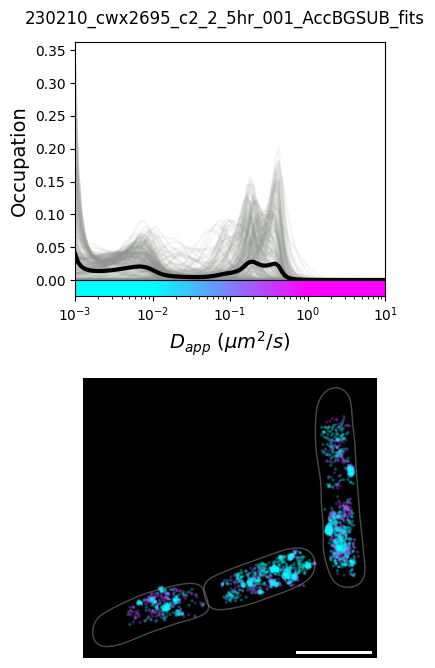

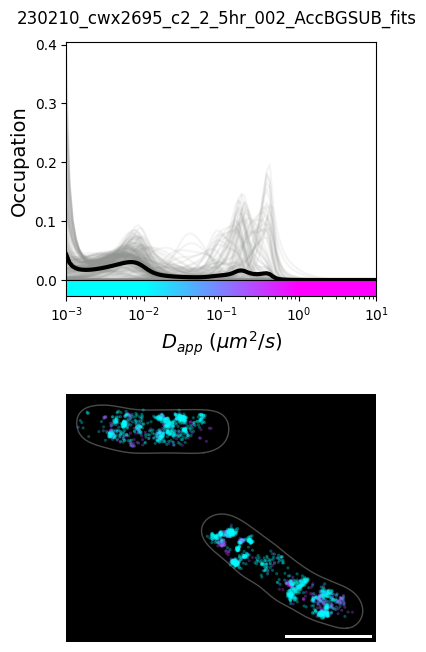

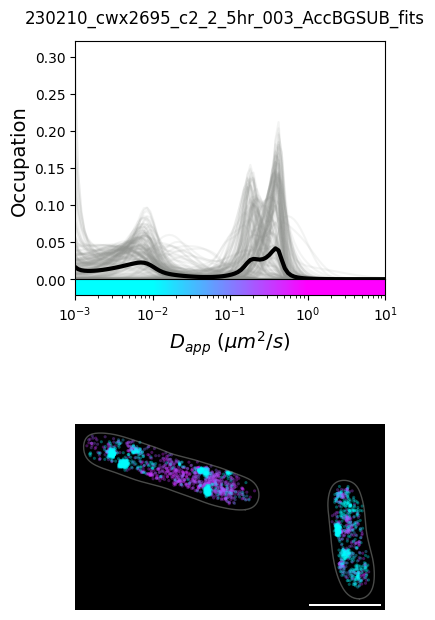

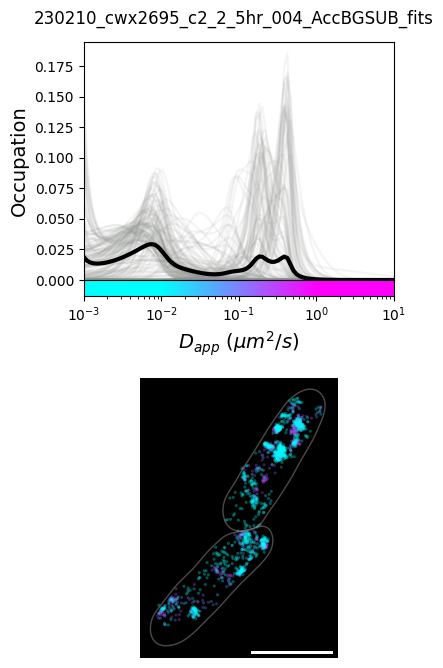

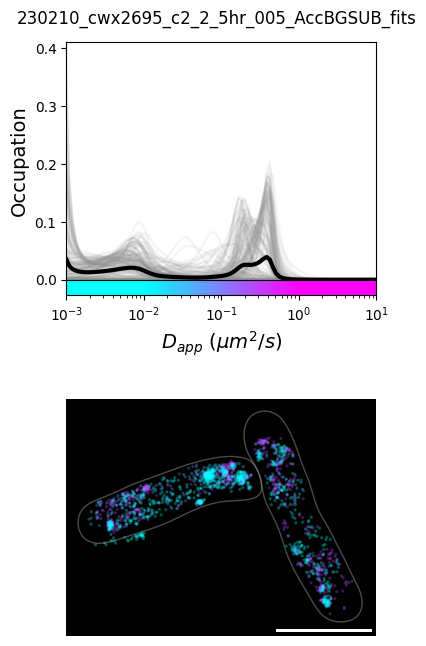

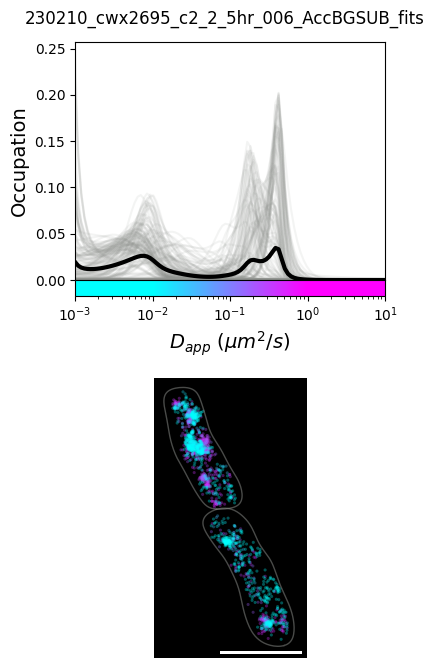

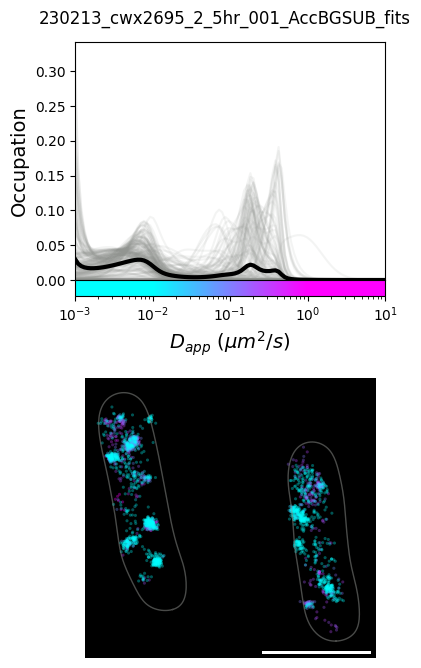

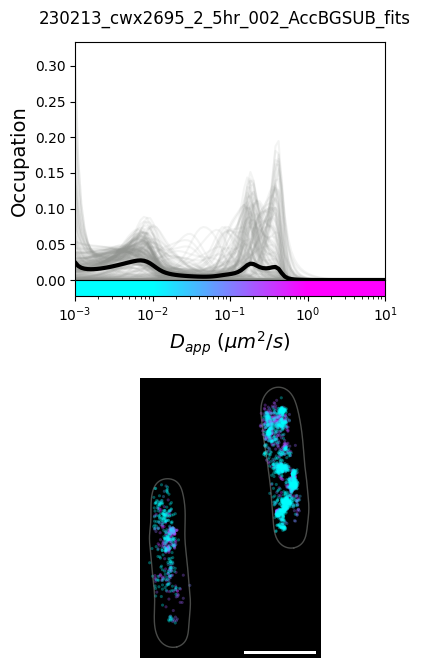

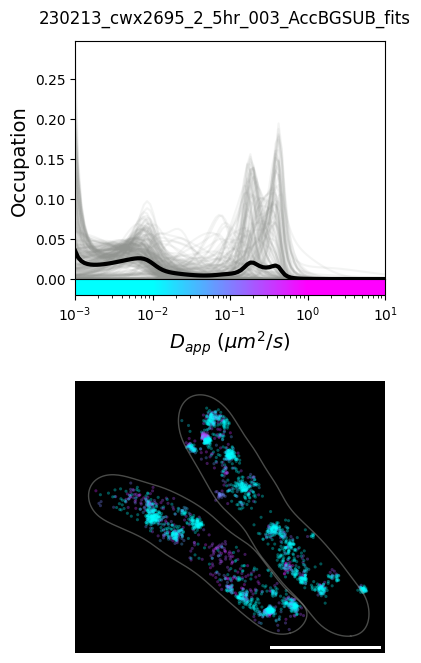

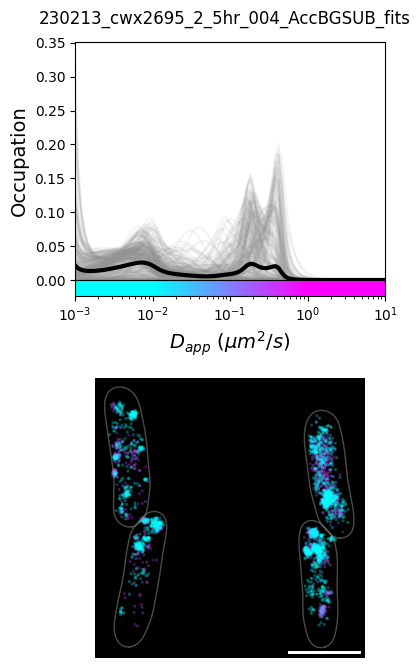

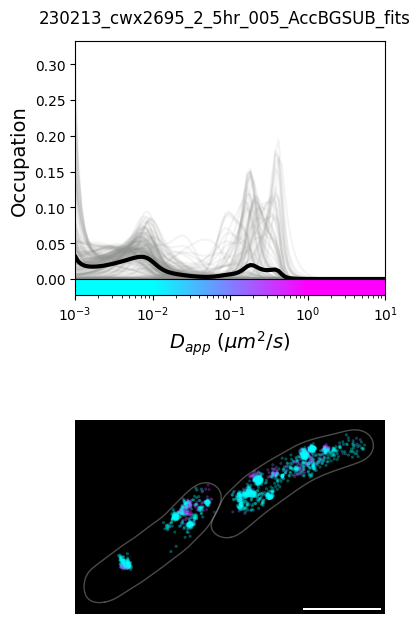

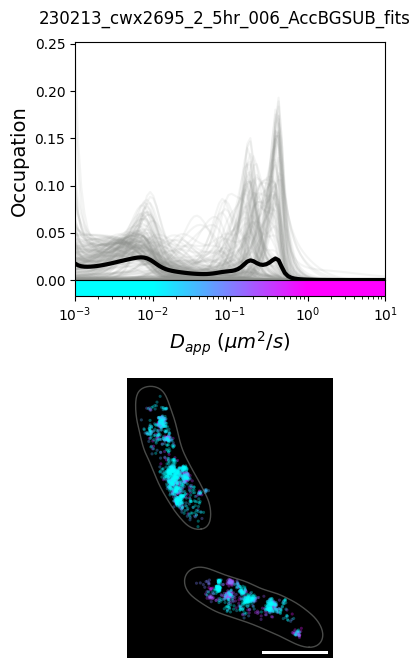

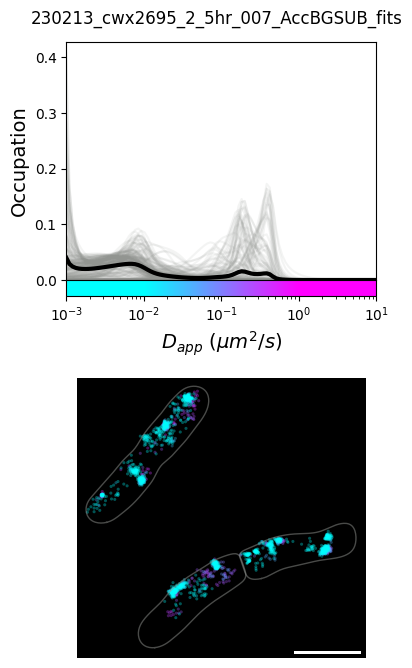

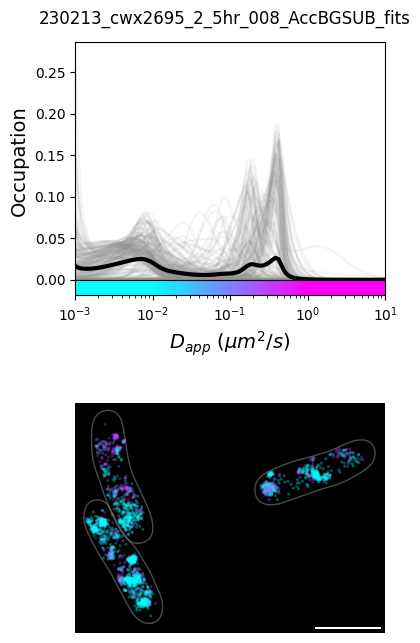

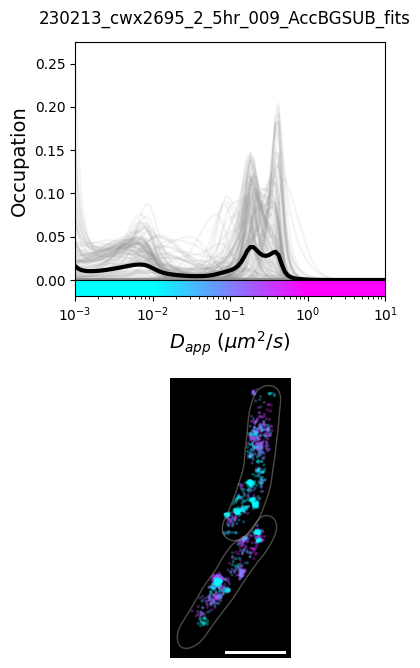

In [14]:
default_scalebar_props = {
    'dx': 0.049,
    'units': 'um',
    'fixed_value': 2,
    'scale_loc': 'none',
    'location': 'lower right',
    'frameon': False,
    'color': 'xkcd:white'
}

for imov in all_fits['movie #'].unique():
    movie_fits = all_fits[all_fits['movie #']==imov]
    movie_fits = movie_fits[~np.isnan(movie_fits['track_id_SA'])]
    movie_track_posteriors = track_posteriors[:, movie_fits['track_id_SA'].unique().astype('int')]

    movie_posterior_occs = (movie_track_posteriors * movie_fits.groupby('track_id_SA')['track_id_SA'].count().values).sum(axis=1) / len(movie_fits)

    phase_mask = phase_masks[imov]
    contours = bu.labels_to_contours(phase_mask, level=0.9)
    # contours = [[smooth_polygon(contour[0])] for contour in contours]
    contours = [[bu.smooth_polygon(contour)] for contour in contours]

    fig, ax = plt.subplots(2,1, figsize=(4,8))
    fig.suptitle(Path(files[imov]).stem, fontsize=12, y=0.92)
    ax[0].set_xscale('log')
    ax[0].set_xlim(left=diff_coefs[0], right=diff_coefs[-1])
    ax[0].set_ylim(bottom=0, top=movie_track_posteriors.max()*1.05)
    ax[0].plot(diff_coefs, movie_track_posteriors,
               color='xkcd:grey',
               lw=1.5,
               alpha=0.1)
    ax[0].plot(diff_coefs, movie_posterior_occs,
               color='xkcd:black',
               lw=3)
    ax[0].set_ylabel('Occupation', fontsize=14)
    
    # cbar = plt.colorbar
    
    ax[1].imshow(np.zeros(phase_mask.shape), cmap='binary_r')
    bu.crop_to_labels(ax[1], phase_mask)
    ax[1].set_axis_off()
    for contour in contours:
        ax[1].plot(contour[0][:,1], contour[0][:,0], lw=1, alpha=0.5, color='xkcd:gray')
    scatmap = ax[1].scatter(
        data=movie_fits.sort_values('D_av', ascending=False),
        # data=movie_fits,
        x='col',
        y='row',
        c='D_av',
        edgecolor='none',
        vmin=1e-3,
        vmax=1e1,
        alpha=0.33,
        s=5,
        cmap=coolramp,
        norm='log')
    ax[0].set_xticks([])
    cbar = plt.colorbar(scatmap,
                        orientation='horizontal',
                        ticks=[1e-3, 1e-2, 1e-1, 1e0, 1e1],
                        ax=ax[0],
                        label=r'$D_{app}\ (\mu m^2/s)$',
                        pad=0)
    
    cbar.solids.set(alpha=1)
    # cbar.set_label(fontsize=14)
    cbar.ax.set_xticklabels(['$\\mathdefault{10^{-3}}$',
                             '$\\mathdefault{10^{-2}}$',
                             '$\\mathdefault{10^{-1}}$',
                             '$\\mathdefault{10^{0}}$',
                             '$\\mathdefault{10^{1}}$'])
    # cbar.ax.tick_params(axis='x', labelsize=18)
    cbar.set_label(r'$D_{app}\ (\mu m^2/s)$', fontsize=14)
    
    scalebar = sb.ScaleBar(**default_scalebar_props)
    ax[1].add_artist(scalebar)
        
    all_figures.append(fig)

## Saving data

### Save figures to PDF

In [20]:
figures_pdf_name = r"SA_ecoli_demo_plots.pdf"

save_folder = join(folder, "state_array_results")
os.makedirs(save_folder, exist_ok=True)

image_pdf = PdfPages(join(save_folder, figures_pdf_name))
for fig in all_figures:
    image_pdf.savefig(fig, bbox_inches='tight')
image_pdf.close()

### Save probabilties to .csv file

In [ ]:
output_csv_name = r"SA_ecoli_demo_output.csv"

output_df = pd.DataFrame(
    data = {
        'diff_coefs': diff_coefs,
        'overall': posterior_occs,
    }
)

for icell in all_fits['roinum_unique'].unique():
    cell_fits = all_fits[all_fits['roinum_unique'] == icell]
    cell_fits = cell_fits[~np.isnan(cell_fits['track_id_SA'])]
    cell_track_posteriors = track_posteriors[:, cell_fits['track_id_SA'].unique().astype('int')]
    cell_posterior_occs = (cell_track_posteriors * cell_fits.groupby('track_id_SA')['track_id_SA'].count().values).sum(axis=1) / len(cell_fits)
    output_df[f'roi{int(icell):03}'] = cell_posterior_occs

output_df.to_csv(
    join(save_folder, output_csv_name)
)